### Imports

In [1]:
import os
import json
import random
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn as nn
from torchsummary import summary

### First determining average size of all the crops, so I can keep a fixed size input to the CNN

In [2]:
def compute_image_dimensions(img_dir="./data/imgs"):
    widths = []
    heights = []
    
    # Iterate over files in the directory
    for filename in os.listdir(img_dir):
        if filename.lower().endswith(".jpg"):
            img_path = os.path.join(img_dir, filename)
            try:
                with Image.open(img_path) as img:
                    w, h = img.size
                    widths.append(w)
                    heights.append(h)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    
    if not widths or not heights:
        print("No images processed successfully.")
        return None
    
    avg_width = np.mean(widths)
    avg_height = np.mean(heights)
    min_width = np.min(widths)
    max_width = np.max(widths)
    min_height = np.min(heights)
    max_height = np.max(heights)
    
    print("Average width:", avg_width)
    print("Average height:", avg_height)
    print("Min width:", min_width)
    print("Max width:", max_width)
    print("Min height:", min_height)
    print("Max height:", max_height)

In [3]:
compute_image_dimensions("./data/imgs")

Average width: 32.559698439600254
Average height: 43.53743206124715
Min width: 7
Max width: 81
Min height: 10
Max height: 98


### Functions for preprocessing and loading

In [4]:
# Preprocessing
transform = transforms.Compose([
    transforms.Resize(64),      # Resize the smaller edge to 64 while keeping aspect ratio
    transforms.CenterCrop(64),  # Ensures final size is 64x64
    transforms.ToTensor()       # Convert to PyTorch tensor (C, H, W)
])

In [5]:
# For each cropped jersey number image (named as <tracklet>_<frame>.jpg), it extracts the <tracklet> part from the name   
# and looks up its ground truth in the JSON file, loads the image, performs transformations, and appends it to a list.

def load_data(img_dir="./data/imgs", gt_file="./data/test_gt.json", multi_label = False):
    with open(gt_file, "r") as f:
        gt_data = json.load(f)
    
    images = []
    labels = []
    
    for filename in os.listdir(img_dir):
        if filename.endswith(".jpg"):
            key = filename.split("_")[0]  # Extract tracklet ID from filename
            label = gt_data[key]

            img_path = os.path.join(img_dir, filename)
            try:
                img = Image.open(img_path).convert("RGB")  
                img_tensor = transform(img)  
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
                continue 
            
            images.append(img_tensor)

            if multi_label:     # i.e. we use separate labels for each digit (so the model will have to output them separately)
                if label == -1:
                    labels.append([10, 10])     # if we use separate labels and the actual label is -1, then both digits should be illegible, denote with 10
                    continue

                tens = label // 10
                ones = label % 10
                labels.append([tens, ones])
            
            else:
                if label == -1:
                    labels.append(0)      # we use 0 to denote the illegible class since nn.CrossEntropyLoss() requires labels starting at 0
                    continue

                labels.append(label)
    
    return torch.stack(images), torch.tensor(labels, dtype=torch.long)  # return Tensors

def plot_label_histogram(labels, multi_label=False):
    """TODO: if multi-label then maybe show two plots, one for each digit?"""

    if multi_label:
        # Convert the tens and ones digits back to the original labels
        labels_as_int = [tens * 10 + ones if tens != 10 and ones != 10 else 0 for tens, ones in labels]
    else:
        labels_as_int = [int(label) for label in labels]
    
    # Set up the bins so that each integer gets its own bar
    bins = np.arange(0, 100 + 2)  # +2 so that the upper value is included
    plt.figure(figsize=(13, 8))
    plt.hist(labels_as_int, bins=bins, edgecolor='black', align='left')
    plt.xlabel("Ground Truth Number")
    plt.ylabel("Frequency")
    plt.title(f"Histogram of Ground Truth Numbers (0-99)")
    plt.xticks(np.arange(0, 100 + 1, step=2))  
    plt.show()

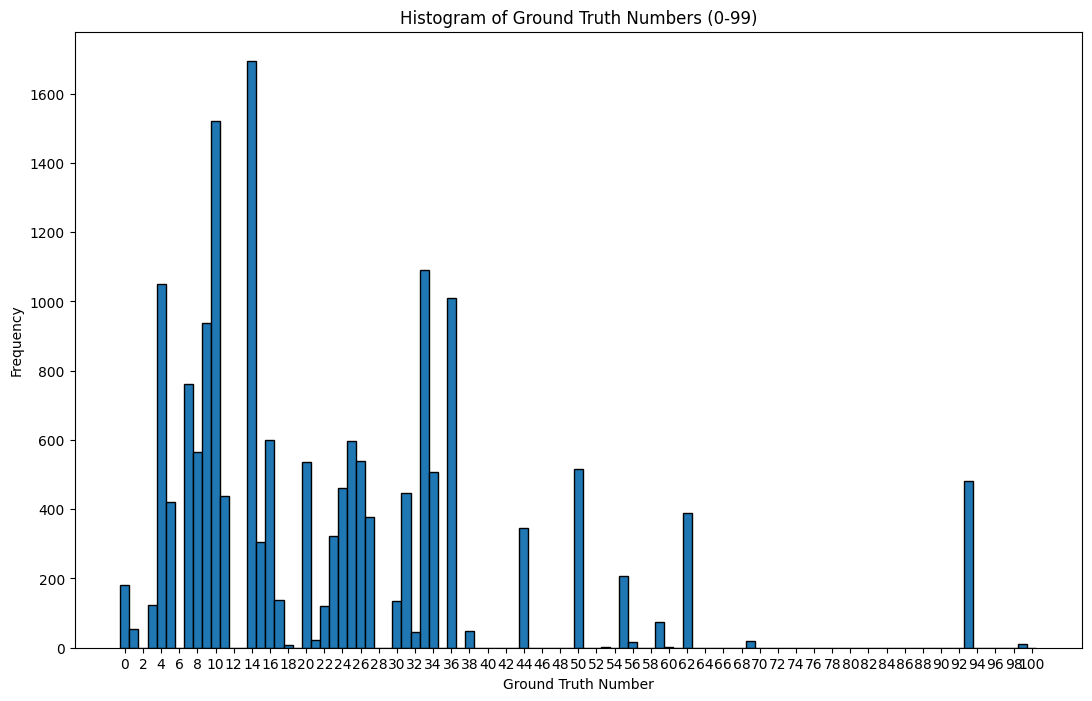

In [6]:
images, labels = load_data("./data/imgs", "./data/test_gt.json")
plot_label_histogram(labels)

It looks like the numbers between 1-35 are common, with 14 having the most inputs.  

In [7]:
dataset = TensorDataset(images, labels)

# 95-5 train-test split
train_size = int(0.95 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# For initial model testing, try to overfit to a small subset of the training data to see if the model has sufficient complexity
small_train_size = int(0.15 * len(train_dataset))
small_indices = random.sample(range(len(train_dataset)), small_train_size)
small_train_dataset = torch.utils.data.Subset(train_dataset, small_indices)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)
small_train_loader = DataLoader(small_train_dataset, batch_size=32, shuffle=True, num_workers=2)

print(f"Total dataset size: {len(dataset)}")
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Small test dataset size: {len(small_train_dataset)}")

Total dataset size: 17111
Train dataset size: 16255
Test dataset size: 856
Small test dataset size: 2438


### Visualizing dataset

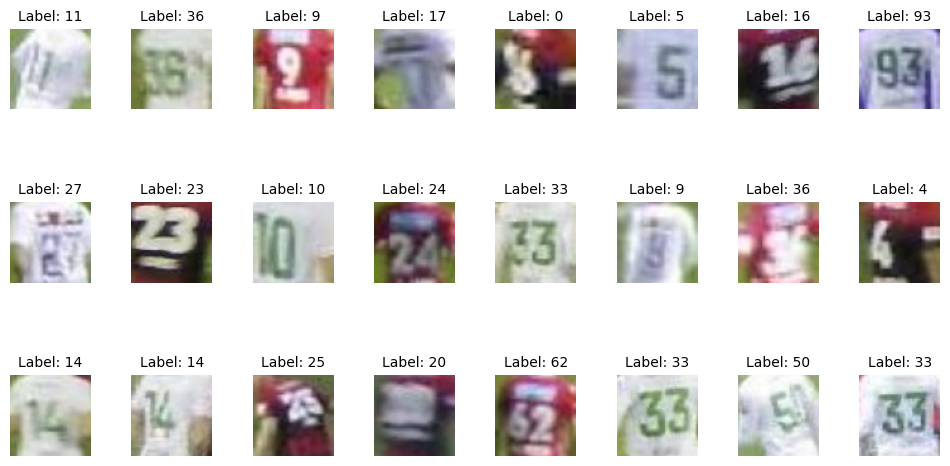

In [8]:
image_batch, label_batch = next(iter(train_loader))  # Get the next batch from the train loader

num_cols = 8
num_rows = 3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))

# Flatten the axes to make it easier to index them
axes = axes.flatten()

for i in range(num_rows * num_cols):
    ax = axes[i]
    image = image_batch[i].permute(1, 2, 0).numpy()  # Convert from CxHxW to HxWxC
    # image = image * 1 + 0  
    ax.imshow(image, cmap='gray')
    ax.set_title(f'Label: {label_batch[i].item()}', fontsize=10)
    ax.axis('off')  # Turn off the axes for each subplot

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

### Training the model

In [9]:
class JerseyNumberClassifier(nn.Module):
    def __init__(self):
        super(JerseyNumberClassifier, self).__init__()
        
        # 64x64 input
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # 32x32 inputs
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # 16x16 inputs
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # 8x8 inputs 
        self.block4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # 4x4 inputs
        self.block5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # 2x2 inputs
        self.block6 = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # 1x1 inputs
        self.fc = nn.Sequential(
            nn.Linear(1024 * 1 * 1, 8192),   # output of last conv block is 1024 * 1 * 1
            nn.ReLU(),
            nn.Linear(8192, 4096),
            nn.ReLU(),
            nn.Linear(4096, 1024),
            nn.ReLU(),
            nn.Linear(1024, 100)
        )
    
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = torch.flatten(x, start_dim=1)  
        x = self.fc(x)
        return x


First, we will try to overfit to a small subset of the training data to ensure that the model is sufficiently complex.

In [10]:
test_net = JerseyNumberClassifier()
summary(test_net, (3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,792
              ReLU-2           [-1, 64, 64, 64]               0
            Conv2d-3           [-1, 64, 64, 64]          36,928
              ReLU-4           [-1, 64, 64, 64]               0
         MaxPool2d-5           [-1, 64, 32, 32]               0
            Conv2d-6          [-1, 128, 32, 32]          73,856
              ReLU-7          [-1, 128, 32, 32]               0
            Conv2d-8          [-1, 128, 32, 32]         147,584
              ReLU-9          [-1, 128, 32, 32]               0
        MaxPool2d-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 256, 16, 16]         295,168
             ReLU-12          [-1, 256, 16, 16]               0
           Conv2d-13          [-1, 256, 16, 16]         590,080
             ReLU-14          [-1, 256,

In [11]:
def training_loop(model, optimizer, criterion, epochs, train_loader, device ):
    total_train_losses = []
    total_train_acc = []

    for epoch in range(epochs):

        total_loss_in_epoch = 0
        correct_preds = 0
        total_preds = 0

        # Training 
        for inputs, ground_truths in train_loader:

            inputs = inputs.to(device)
            ground_truths = ground_truths.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)    
            loss = criterion(outputs, ground_truths)     
            loss.backward()
            optimizer.step()

            total_loss_in_epoch += loss.item()       # accumulate loss for this batch
            correct_preds += (torch.argmax(outputs, dim=1) == ground_truths).sum().item()
            total_preds += outputs.size(0)

        # average out the loss and accuracy across the batch
        avg_train_loss = round(total_loss_in_epoch / inputs.size(0), 4)
        train_accuracy = round((correct_preds / total_preds) * 100, 4)

        total_train_losses.append(avg_train_loss)
        total_train_acc.append(train_accuracy)

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {avg_train_loss} | Train Accuracy: {train_accuracy}% \nNumber of jersey numbers correctly predicted: {correct_preds}")
        print("=" * 20)


In [12]:
# Use MPS (Apple GPU) if available; otherwise, fall back to CPU
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

#DEVICE = torch.device("cuda")

test_net.to(DEVICE)

JerseyNumberClassifier(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), pad

In [ ]:
epochs = 55
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(test_net.parameters(), lr=0.0001)
training_loop(test_net, optimizer, criterion, epochs, small_train_loader, DEVICE)

Epoch 1/50
Train Loss: 45.7472 | Train Accuracy: 8.1624% 
Number of jersey numbers correctly predicted: 199
Epoch 2/50
Train Loss: 42.4044 | Train Accuracy: 9.639% 
Number of jersey numbers correctly predicted: 235
Epoch 3/50
Train Loss: 42.306 | Train Accuracy: 8.0804% 
Number of jersey numbers correctly predicted: 197
Epoch 4/50
Train Loss: 42.1066 | Train Accuracy: 9.7621% 
Number of jersey numbers correctly predicted: 238
Epoch 5/50
Train Loss: 42.0197 | Train Accuracy: 9.557% 
Number of jersey numbers correctly predicted: 233
Epoch 6/50
Train Loss: 41.897 | Train Accuracy: 9.8441% 
Number of jersey numbers correctly predicted: 240
Epoch 7/50
Train Loss: 41.9471 | Train Accuracy: 10.2543% 
Number of jersey numbers correctly predicted: 250
Epoch 8/50
Train Loss: 41.9275 | Train Accuracy: 9.6801% 
Number of jersey numbers correctly predicted: 236
Epoch 9/50
Train Loss: 41.866 | Train Accuracy: 8.9007% 
Number of jersey numbers correctly predicted: 217
Epoch 10/50
Train Loss: 41.9111 

We were able to overfit the model to a near-100% training accuracy on a small sample of training data (over 50 epochs)

In [14]:
def evaluate_model (model, test_loader, device):
  model.eval()

  correct = 0
  total = 0

  #disable gradient computation
  with torch.no_grad():
    # iterate over test batches
    for inputs, labels in test_loader:
      # moving inputs and labels to gpu
      inputs, labels = inputs.to(device), labels.to(device)

      #forward pass
      outputs = model(inputs)

      #get prediction
      _, predicted = torch.max(outputs, 1)

      # update total samples and correct predictions
      total += labels.size(0)
      correct += (predicted==labels).sum().item()

  #compute accuracy
  accuracy = 100 * correct/total
  print(f"Test Accuracy: {accuracy:.2f}%")

evaluate_model(test_net, test_loader, DEVICE)

Test Accuracy: 47.43%


Looking at the examples it got wrong:

In [15]:
wrong_images = []
wrong_labels = []
wrong_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = test_net(inputs)
        _, preds = torch.max(outputs, 1)

        # Check each image in the batch for misclassification
        for i in range(len(labels)):
            if preds[i] != labels[i].item():
                wrong_images.append(inputs[i].cpu())
                wrong_labels.append(labels[i].cpu().item())
                wrong_predictions.append(preds[i].cpu().item())


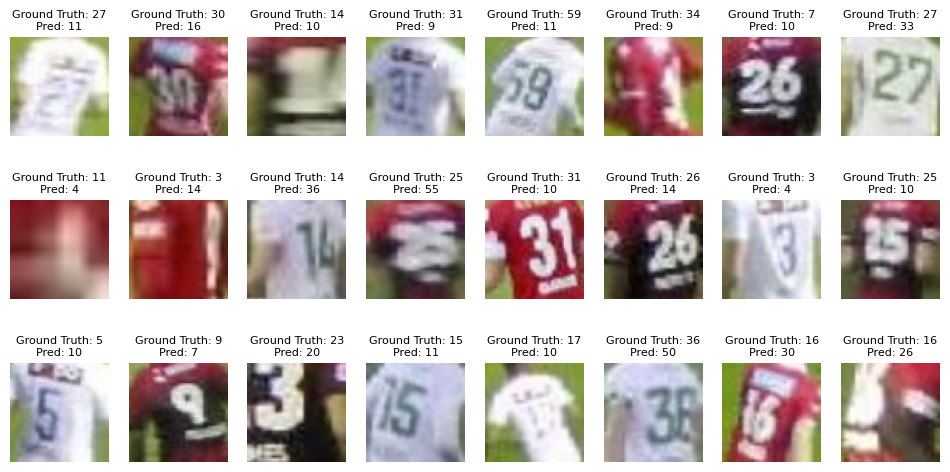

In [16]:
num_cols = 8
num_rows = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))

# Flatten the axes to make it easier to index them
axes = axes.flatten()

for i in range(num_rows * num_cols):
    if i < len(images):  # so that we don't try to access more images than available in the batch
        ax = axes[i]
        image = wrong_images[i]
        # Convert from CxHxW to HxWxC for plotting
        image_np = image.permute(1, 2, 0).numpy()

        ax.imshow(image_np, cmap='gray')
        ax.set_title(f"Ground Truth: {wrong_labels[i]}\nPred: {wrong_predictions[i]}", fontsize=8)
        ax.axis('off')
    else:
        ax = axes[i]
        ax.axis('off')

plt.subplots_adjust()
plt.show()


Now we will try to train the model over the entire training dataset

In [17]:
# Training same model over more training data
epochs = 15
test_net.train()
training_loop(test_net, optimizer, criterion, epochs, train_loader, DEVICE)

Epoch 1/15
Train Loss: 22.0934 | Train Accuracy: 59.1756% 
Number of jersey numbers correctly predicted: 9619
Epoch 2/15
Train Loss: 15.5678 | Train Accuracy: 71.3073% 
Number of jersey numbers correctly predicted: 11591
Epoch 3/15
Train Loss: 11.5511 | Train Accuracy: 78.8311% 
Number of jersey numbers correctly predicted: 12814
Epoch 4/15
Train Loss: 8.6564 | Train Accuracy: 84.331% 
Number of jersey numbers correctly predicted: 13708
Epoch 5/15
Train Loss: 6.4352 | Train Accuracy: 88.502% 
Number of jersey numbers correctly predicted: 14386
Epoch 6/15
Train Loss: 4.868 | Train Accuracy: 91.2519% 
Number of jersey numbers correctly predicted: 14833
Epoch 7/15
Train Loss: 3.9481 | Train Accuracy: 93.036% 
Number of jersey numbers correctly predicted: 15123
Epoch 8/15
Train Loss: 3.2212 | Train Accuracy: 94.2971% 
Number of jersey numbers correctly predicted: 15328
Epoch 9/15
Train Loss: 2.5631 | Train Accuracy: 95.3737% 
Number of jersey numbers correctly predicted: 15503
Epoch 10/15


In [18]:
# test model
evaluate_model(test_net, test_loader, DEVICE)

Test Accuracy: 87.03%


In [19]:
# Training new model over all trainig data from scratch
net = JerseyNumberClassifier()
net.to(DEVICE)
epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)
training_loop(net, optimizer, criterion, epochs, train_loader, DEVICE)

Epoch 1/10
Train Loss: 54.7246 | Train Accuracy: 9.1664% 
Number of jersey numbers correctly predicted: 1490
Epoch 2/10
Train Loss: 50.0636 | Train Accuracy: 9.2033% 
Number of jersey numbers correctly predicted: 1496
Epoch 3/10
Train Loss: 45.2071 | Train Accuracy: 14.5063% 
Number of jersey numbers correctly predicted: 2358
Epoch 4/10
Train Loss: 37.8289 | Train Accuracy: 24.9216% 
Number of jersey numbers correctly predicted: 4051
Epoch 5/10
Train Loss: 29.2555 | Train Accuracy: 40.08% 
Number of jersey numbers correctly predicted: 6515
Epoch 6/10
Train Loss: 20.361 | Train Accuracy: 60.0431% 
Number of jersey numbers correctly predicted: 9760
Epoch 7/10
Train Loss: 13.3205 | Train Accuracy: 75.6383% 
Number of jersey numbers correctly predicted: 12295
Epoch 8/10
Train Loss: 9.1075 | Train Accuracy: 83.8265% 
Number of jersey numbers correctly predicted: 13626
Epoch 9/10
Train Loss: 6.6999 | Train Accuracy: 88.2252% 
Number of jersey numbers correctly predicted: 14341
Epoch 10/10
Tr

In [20]:
# test model
evaluate_model(net, test_loader, DEVICE)

Test Accuracy: 87.15%


# Data augmentation

In [ ]:
# To-Do: augment data and train model over new dataset to reduce overfitting


# Attempting a Digit-wise Classifier

In [24]:
class JerseyNumberMultiLabelClassifier(nn.Module):
    def __init__(self):
        super(JerseyNumberMultiLabelClassifier, self).__init__()
        
        # 64x64 input
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # 32x32 inputs
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # 16x16 inputs
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # 8x8 inputs 
        self.block4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # 4x4 inputs
        self.block5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # 2x2 inputs
        self.block6 = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # Shared fully-connected layers
        self.shared_fc = nn.Sequential(
            nn.Linear(1024 * 1 * 1, 8192),   # flatten 1024*1*1 features
            nn.ReLU(),
            nn.Linear(8192, 4096),
            nn.ReLU(),
            nn.Linear(4096, 1024),
            nn.ReLU(),
        )
        
        # Two separate classifier heads, each for 11 classes (0-9 digits and 10 for illegible)
        self.fc_digit1 = nn.Linear(1024, 11)
        self.fc_digit2 = nn.Linear(1024, 11)
    
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = torch.flatten(x, start_dim=1)  
        x = self.shared_fc(x)
        out_digit1 = self.fc_digit1(x)
        out_digit2 = self.fc_digit2(x)
        return out_digit1, out_digit2


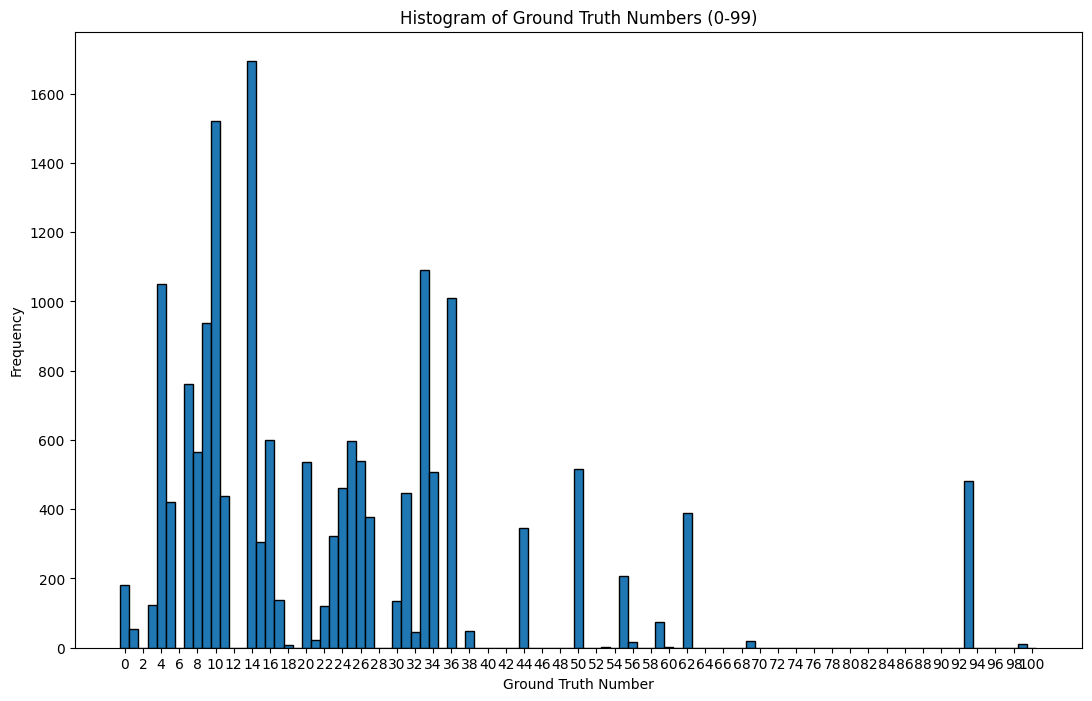

In [25]:
# Reinitialize images and labels
images, labels = load_data("./data/imgs", "./data/test_gt.json", multi_label=True)
plot_label_histogram(labels, multi_label=True)

Data looks the same, so create new dataloaders

In [26]:
dataset = TensorDataset(images, labels)

# 95-5 train-test split
train_size = round(0.95 * len(dataset))
test_size = round(0.05 * len(dataset))
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# For initial model testing, try to overfit to a small subset of the training data to see if the model has sufficient complexity
small_train_size = int(0.15 * len(train_dataset))
small_train_dataset = torch.utils.data.Subset(train_dataset, range(small_train_size)) 

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)
small_train_loader = DataLoader(small_train_dataset, batch_size=32, shuffle=True, num_workers=2)

print(f"Total dataset size: {len(dataset)}")
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Small test dataset size: {len(small_train_dataset)}")

Total dataset size: 17111
Train dataset size: 16255
Test dataset size: 856
Small test dataset size: 2438


In [27]:
digitwise_net = JerseyNumberMultiLabelClassifier()
#digitwise_net = digitwise_net.to(DEVICE)
summary(digitwise_net, (3,64,64))

digitwise_net = digitwise_net.to(DEVICE)
digitwise_optimizer = torch.optim.Adam(digitwise_net.parameters(), lr = 0.001)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,792
              ReLU-2           [-1, 64, 64, 64]               0
            Conv2d-3           [-1, 64, 64, 64]          36,928
              ReLU-4           [-1, 64, 64, 64]               0
         MaxPool2d-5           [-1, 64, 32, 32]               0
            Conv2d-6          [-1, 128, 32, 32]          73,856
              ReLU-7          [-1, 128, 32, 32]               0
            Conv2d-8          [-1, 128, 32, 32]         147,584
              ReLU-9          [-1, 128, 32, 32]               0
        MaxPool2d-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 256, 16, 16]         295,168
             ReLU-12          [-1, 256, 16, 16]               0
           Conv2d-13          [-1, 256, 16, 16]         590,080
             ReLU-14          [-1, 256,

In [28]:
total_train_losses = []
total_train_acc = []
TEST_EPOCHS = 10

for epoch in range(TEST_EPOCHS):

    total_loss_in_epoch = 0
    correct_preds = 0
    total_preds = 0

    # Training 
    for inputs, ground_truths in small_train_loader:

        inputs = inputs.to(DEVICE)
        ground_truths = ground_truths.to(DEVICE)
        
        optimizer.zero_grad()
        out_digit1, out_digit2 = digitwise_net(inputs)
        
        # Compute the loss for each digit classification separately.
        loss1 = criterion(out_digit1, ground_truths[:, 0])
        loss2 = criterion(out_digit2, ground_truths[:, 1])
        loss = (loss1 + loss2) / 2  # average the losses

        loss.backward()
        optimizer.step()

        total_loss_in_epoch += loss.item()  # accumulate loss for this batch

        # Check for accuracy for each digit separately
        correct_digit1 = torch.argmax(out_digit1, dim=1) == ground_truths[:, 0]
        correct_digit2 = torch.argmax(out_digit2, dim=1) == ground_truths[:, 1]
        correct_preds += (correct_digit1 & correct_digit2).sum().item()     # AND (bitwise operation) the losses 
        total_preds += out_digit1.size(0)

    # average out the loss and accuracy across the batch
    avg_train_loss = round(total_loss_in_epoch / inputs.size(0), 4)
    train_accuracy = round((correct_preds / total_preds) * 100, 4)

    total_train_losses.append(avg_train_loss)
    total_train_acc.append(train_accuracy)

    print(f"Epoch {epoch+1}/{TEST_EPOCHS}")
    print(f"Train Loss: {avg_train_loss} | Train Accuracy: {train_accuracy}% \nNumber of jersey numbers correctly predicted: {correct_preds}")
    print("=" * 20)


Epoch 1/10
Train Loss: 30.7251 | Train Accuracy: 0.0% 
Number of jersey numbers correctly predicted: 0
Epoch 2/10
Train Loss: 30.7245 | Train Accuracy: 0.0% 
Number of jersey numbers correctly predicted: 0
Epoch 3/10
Train Loss: 30.725 | Train Accuracy: 0.0% 
Number of jersey numbers correctly predicted: 0
Epoch 4/10
Train Loss: 30.7248 | Train Accuracy: 0.0% 
Number of jersey numbers correctly predicted: 0
Epoch 5/10
Train Loss: 30.726 | Train Accuracy: 0.0% 
Number of jersey numbers correctly predicted: 0
Epoch 6/10
Train Loss: 30.7245 | Train Accuracy: 0.0% 
Number of jersey numbers correctly predicted: 0
Epoch 7/10
Train Loss: 30.7241 | Train Accuracy: 0.0% 
Number of jersey numbers correctly predicted: 0
Epoch 8/10
Train Loss: 30.7267 | Train Accuracy: 0.0% 
Number of jersey numbers correctly predicted: 0
Epoch 9/10
Train Loss: 30.7249 | Train Accuracy: 0.0% 
Number of jersey numbers correctly predicted: 0
Epoch 10/10
Train Loss: 30.7257 | Train Accuracy: 0.0% 
Number of jersey nu

# Multi-task learning with multiple loss functions
Based on paper: GENERALIZED JERSEY NUMBER RECOGNITION USING MULTI-TASK LEARNING WITH ORIENTATION-GUIDED WEIGHT REFINEMENT
1. Tens digit classification (0–9, with 10 for single-digit numbers or non-visible tens)
2. Ones digit classification (0–9, with 10 for missing ones digit or non-visible ones)
3. Binary classification of number length (1-digit or 2-digit)
4. Holistic number classification (predicting the full number from 0–99, 100 for illegible)

In [50]:
class JerseyNumberMultiLoss(nn.Module):
    def __init__(self):
        super(JerseyNumberMultiLoss, self).__init__()
        
        # Convolutional feature extractor
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.block4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.block5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.block6 = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.fc = nn.Sequential(
            nn.Linear(1024 * 1 * 1, 8192),  
            nn.ReLU(),
            nn.Linear(8192, 4096),
            nn.ReLU(),
            nn.Linear(4096, 1024),
            nn.ReLU(),
        )
        
        # Output heads
        self.tens_output = nn.Linear(1024, 11)   # 0-9 + "empty digit" class (10)
        self.ones_output = nn.Linear(1024, 11)   # 0-9 + "empty digit" class (10)
        self.length_output = nn.Linear(1024, 2)  # Binary classification (1-digit or 2-digit)
        self.holistic_output = nn.Linear(1024, 101)  # Directly predict the full number (0-99) + 100 for illegible

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)

        tens_pred = self.tens_output(x)
        ones_pred = self.ones_output(x)
        length_pred = self.length_output(x)
        holistic_pred = self.holistic_output(x)

        return tens_pred, ones_pred, length_pred, holistic_pred


In [56]:
def compute_loss(tens_pred, ones_pred, length_pred, holistic_pred, 
                 tens_label, ones_label, length_label, holistic_label):
    
    criterion = nn.CrossEntropyLoss()
    
    loss_tens = criterion(tens_pred, tens_label)
    loss_ones = criterion(ones_pred, ones_label)
    loss_length = criterion(length_pred, length_label)
    loss_holistic = criterion(holistic_pred, holistic_label)

    total_loss = loss_tens + loss_ones + loss_length + loss_holistic  # Weighted sum?

    return total_loss
